# Double spike grid

Calculations are complete but documentation needs to be added.

In [1]:
import isopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from matplotlib.axes import Axes
from datetime import datetime
import io
from PIL import Image

In [5]:
raw_ORNL_spikes = isopy.IsopyDict(isopy.read_csv('ORNL_spikes.csv'))
spike_keys = raw_ORNL_spikes.keylist()
ORNL_spikes = isopy.IsopyDict()

for key, values in raw_ORNL_spikes.items():
    element_keys = spike_keys.filter(element_symbol=key.element_symbol)
    ORNL_spikes[key] = isopy.array(dict(zip(element_keys, values)))

In [6]:
ORNL_spikes['fe57']

(row) , 54Fe   , 56Fe   , 57Fe   , 58Fe   
None  , 0.0007 , 0.0004 , 0.9288 , 0.0125 

In [7]:
ORNL_spikes['fe58']

(row) , 54Fe  , 56Fe   , 57Fe   , 58Fe   
None  , 8e-05 , 0.0001 , 0.0005 , 0.8458 

In this example we are going to model the outcomes of double spiking iron isotopes.

In [100]:
element = 'fe'
interferences = dict(cr=0.001, ni=0.001) #Proportion of these elements relative to *element*
fixed_isotope = 'fe54' #One of the unspiked isotopes in the inversion
spike1 = isopy.array(fe54=0, fe56=0, fe57=1, fe58=0)
spike2 = isopy.array(fe54=0, fe56=0, fe57=0, fe58=1)
spike1 = isopy.array(fe54=0.0001, fe56=0.0167, fe57=0.9823, fe58=0.0008) #ORNL spike composition
spike2 = isopy.array(fe54=0.006, fe56=0.1378, fe57=0.00125, fe58=0.8458) #ORNL spike composition
axes_labels = dict(axes_xlabel = 'Proportion of double spike in double spike-sample mix', axes_ylabel='Proportion of spike1 in double spike')

#These are taken from the first grid below
optimal_spike1_fraction = 0.5
optimal_doublespike_fraction = 0.45

optimal_spike = spike1 * optimal_spike1_fraction + spike2 * (1-optimal_spike1_fraction)
fixed_voltage = isopy.tb.make_ms_sample(element, spike=optimal_spike, spike_fraction=optimal_doublespike_fraction, fins=2, integrations=None, fixed_key=None)[fixed_isotope]
print(f'The signal on {isopy.keystring(fixed_isotope)} is fixed to {fixed_voltage:.3f} v')

The signal on 54Fe is fixed to 0.306 v


In [39]:
grid1 = isopy.tb.ds_grid(element, spike1, spike2)

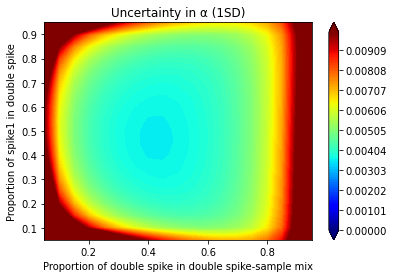

In [48]:
isopy.tb.plot_contours(plt, *grid1.xyz(), zmin= 0, zmax=0.01, **axes_labels, axes_title = 'Uncertainty in α (1SD)')

In [49]:
grid2 = isopy.tb.ds_grid('fe', spike1, spike2, random_seed=None)

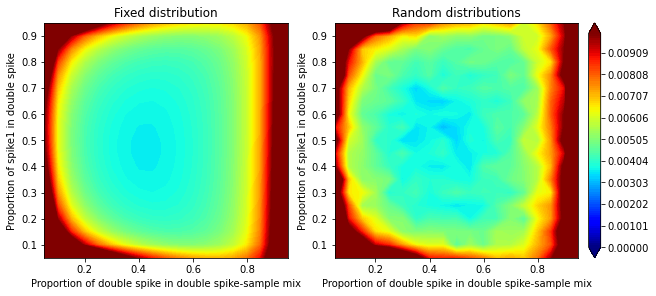

In [50]:
axes = isopy.tb.create_subplots(plt, [['left', 'right', 'colorbar']], figure_size=(9,4), gridspec_width_ratios = [1,1,0.05])

isopy.tb.plot_contours(axes['left'], *grid1.xyz(), zmin= 0, zmax=0.01, colorbar=axes['colorbar'], **axes_labels, axes_title='Fixed distribution')
isopy.tb.plot_contours(axes['right'], *grid2.xyz(), zmin= 0, zmax=0.01, colorbar=False, **axes_labels, axes_title='Random distributions')

In [103]:
grid3 = isopy.tb.ds_grid(element, spike1, spike2, fixed_voltage=fixed_voltage, fixed_key=fixed_isotope)

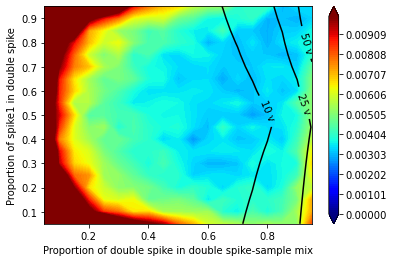

In [102]:
x3, y3, z3 = grid3.xyz()
z3_max = np.nanmax(grid3.input.measured, axis=None)

isopy.tb.plot_contours(plt, x3, y3, z3, zmin= 0, zmax=0.01, **axes_labels, colors='jet')
isopy.tb.plot_contours(plt, x3, y3, z3_max, levels=[5, 10, 25, 50, 100], filled=False, colors=['black'], label=True, label_fmt='%d v')

In [93]:
grid4 = isopy.tb.ds_grid(element, spike1, spike2, fixed_voltage=fixed_voltage, fixed_key=fixed_isotope, resistor={'fe54': 1E12})

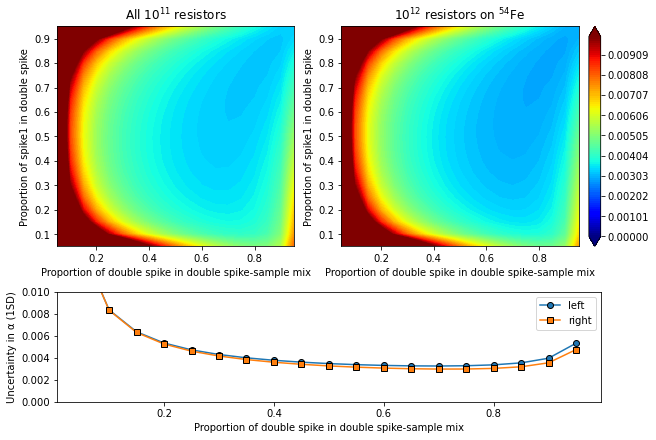

In [94]:
axes = isopy.tb.create_subplots(plt, [['left', 'right', 'colorbar'], ['compare', 'compare', 'compare']] , figure_size=(9,6), gridspec_width_ratios = [1,1,0.05], gridspec_height_ratios=[1, 0.5])

isopy.tb.plot_contours(axes['left'], *grid3.xyz(), zmin= 0, zmax=0.01, colorbar = axes['colorbar'], **axes_labels, axes_title='All $10^{11}$ resistors')
isopy.tb.plot_contours(axes['right'], *grid4.xyz(), zmin= 0, zmax=0.01, colorbar = False, **axes_labels, axes_title='$10^{12}$ resistors on ${}^{54}$Fe')

isopy.tb.plot_scatter(axes['compare'], *grid3.xz(optimal_spike1_fraction), line=True, label='left')
isopy.tb.plot_scatter(axes['compare'], *grid4.xz(optimal_spike1_fraction), line=True, label='right')
isopy.tb.update_axes(axes['compare'], ylim = (0, 0.01), legend=True, ylabel='Uncertainty in α (1SD)', xlabel='Proportion of double spike in double spike-sample mix')

In [56]:
#the addition of interferences will considerably slow down the function.
grid5 = isopy.tb.ds_grid(element, spike1, spike2, fixed_voltage=fixed_voltage, fixed_key=fixed_isotope, interferences = interferences)

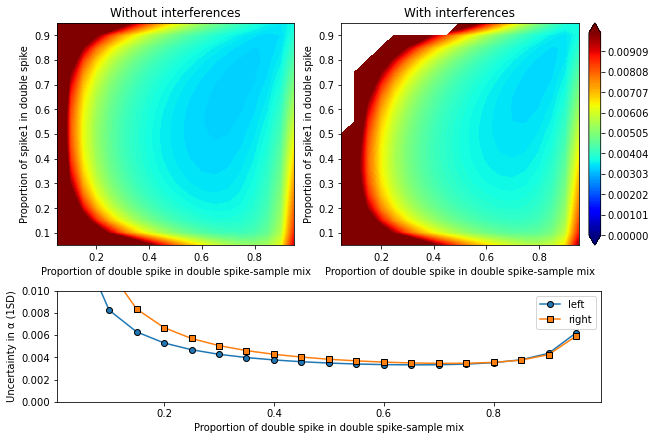

In [57]:
axes = isopy.tb.create_subplots(plt, [['left', 'right', 'colorbar'], ['compare', 'compare', 'compare']] , figure_size=(9,6), gridspec_width_ratios = [1,1,0.05], gridspec_height_ratios=[1, 0.5])

isopy.tb.plot_contours(axes['left'], *grid3.xyz(), zmin= 0, zmax=0.01, colorbar = axes['colorbar'], **axes_labels, axes_title='Without interferences')
isopy.tb.plot_contours(axes['right'], *grid5.xyz(), zmin= 0, zmax=0.01, colorbar=False, **axes_labels, axes_title='With interferences')

isopy.tb.plot_scatter(axes['compare'], *grid3.xz(optimal_spike1_fraction), line=True, label='left', axes_ylim = (0, 0.01), axes_ylabel='Uncertainty in α (1SD)')
isopy.tb.plot_scatter(axes['compare'], *grid5.xz(optimal_spike1_fraction), line=True, label='right', axes_legend=True, axes_xlabel='Proportion of double spike in double spike-sample mix')

In [60]:
time_rudge = datetime.now()
grid_rudge = isopy.tb.ds_grid(element, spike1, spike2, method='rudge', fixed_voltage=fixed_voltage, fixed_key=fixed_isotope)
time_rudge = datetime.now() - time_rudge

time_siebert = datetime.now()
grid_siebert = isopy.tb.ds_grid(element, spike1, spike2, method='siebert',fixed_voltage=fixed_voltage, fixed_key=fixed_isotope)
time_siebert = datetime.now() - time_siebert

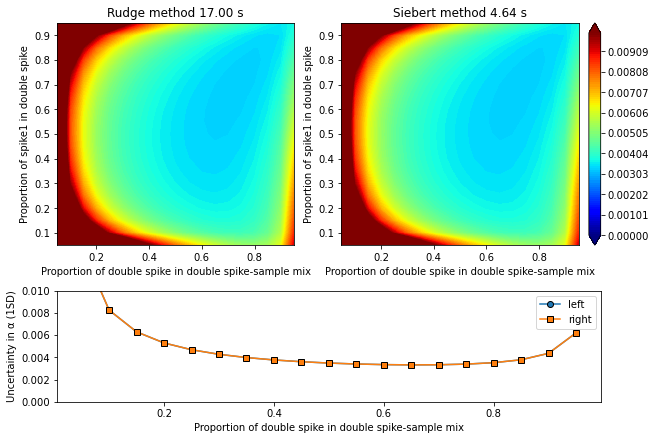

In [61]:
axes = isopy.tb.create_subplots(plt, [['left', 'right', 'colorbar'], ['compare', 'compare', 'compare']] , figure_size=(9,6), gridspec_width_ratios = [1,1,0.05], gridspec_height_ratios=[1, 0.5])

isopy.tb.plot_contours(axes['left'], *grid_rudge.xyz(), zmin= 0, zmax=0.01, colorbar = axes['colorbar'], **axes_labels, axes_title=f'Rudge method {time_rudge.total_seconds():.2f} s')
isopy.tb.plot_contours(axes['right'], *grid_siebert.xyz(), zmin= 0, zmax=0.01, colorbar=False, **axes_labels, axes_title=f'Siebert method {time_siebert.total_seconds():.2f} s')

isopy.tb.plot_scatter(axes['compare'], *grid_rudge.xz(optimal_spike1_fraction), line=True, label='left', axes_ylim = (0, 0.01), axes_ylabel='Uncertainty in α (1SD)')
isopy.tb.plot_scatter(axes['compare'], *grid_siebert.xz(optimal_spike1_fraction), line=True, label='right', axes_legend=True, axes_xlabel='Proportion of double spike in double spike-sample mix')

In [49]:
element = 'fe'
fixed_voltage = 10
fixed_key = None
use_fixed_key = False

fixed_values = isopy.tb.make_ms_array(element, mf_factor=2).normalise(fixed_voltage, fixed_key)
all_isotopes = isopy.refval.element.isotopes[element]

all_spikes = {}
for isotope in all_isotopes:
    sp = isopy.zeros(None, keys=all_isotopes)
    sp[isotope] = 1
    all_spikes[isotope] = sp
   
fixed_values

(row) , 54Fe    , 56Fe   , 57Fe    , 58Fe     
None  , 0.54525 , 9.2042 , 0.22025 , 0.030335 

In [50]:
%%time
isotope_combinations = list(itertools.combinations(all_isotopes, 4))
progress = widgets.IntProgress(value=0, min=0, max = len(isotope_combinations)*6 , description=f'Calculating: ')
display(progress)

results = []
subplots = []
for r, keys in enumerate(isotope_combinations):
    keys = isopy.askeylist(keys)
    results.append([])
    subplots.append([])
    for sp1_key, sp2_key in itertools.combinations(keys, 2):
        sp1 = all_spikes[sp1_key]
        sp2 = all_spikes[sp2_key]
        
        subplot = f'ds{keys[0].mass_number[-1]}{keys[1].mass_number[-1]}{keys[2].mass_number[-1]}{keys[3].mass_number[-1]}_{sp1_key.mass_number[-1]}{sp2_key.mass_number[-1]}'
        
        subplots[-1].append(subplot)
        if use_fixed_key:
            fx_key = (keys - sp1_key - sp2_key)[0] #Use first unspiked isotope
            fx_voltage = fixed_values[fx_key]
            results[-1].append( (subplot, keys, sp1_key, sp2_key, isopy.tb.ds_grid(element, sp1, sp2, fixed_voltage = fx_voltage, fixed_key=fx_key, inversion_keys = keys)) )
        else:
            results[-1].append( (subplot, keys, sp1_key, sp2_key, isopy.tb.ds_grid(element, sp1, sp2, fixed_voltage = fixed_voltage, inversion_keys = keys)) )
        progress.value += 1
        
    subplots[-1].append(f'colorbar{r}')
progress.bar_style = 'success'

IntProgress(value=0, description='Calculating: ', max=6)

Wall time: 30.6 s


Wall time: 2.36 s


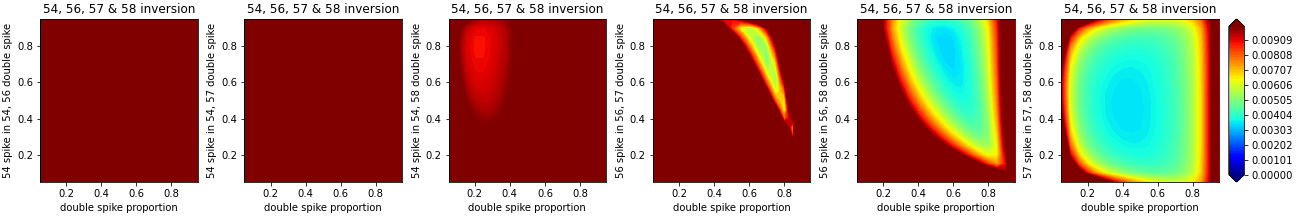

<Figure size 1296x216 with 0 Axes>

In [51]:
%%time
zmin, zmax = 0, 0.01
images = []

#Plot each row individually and join the images together in the end.
#This is faster than plotting them all at once with matplotlib.
for r, row in enumerate(results):
    plt.clf()
    axes = isopy.tb.create_subplots(plt, [subplots[r]], figure_width = 18, figure_height=3, gridspec_width_ratios = [1,1,1,1,1,1,0.1])
    colorbar = axes[f'colorbar{r}']
    for col in row:
        subplot, keys, sp1_key, sp2_key, grid = col
        subplot = axes[subplot]
        xlabel = 'double spike proportion'
        ylabel = f'{sp1_key.mass_number} spike in {sp1_key.mass_number}, {sp2_key.mass_number} double spike'
        title = f'{keys[0].mass_number}, {keys[1].mass_number}, {keys[2].mass_number} & {keys[3].mass_number} inversion'
        
        isopy.tb.plot_contours(subplot, *grid.xyz(isopy.nansd), zmin=zmin, zmax=zmax, axes_xlabel=xlabel, axes_ylabel=ylabel, axes_title=title, colorbar=colorbar)
        colorbar = False
    
    #Create image as bytes
    save = io.BytesIO()
    plt.savefig(save, format='png')
    images.append(Image.open(save))

#stitch images together into one large image
image = Image.new(images[0].mode, (images[0].width, sum([im.height for im in images])))
for i, im in enumerate(images): image.paste(im, (0, im.height*i))
plt.clf() #Otherwise the last plt is shown
image #displays image